In [1]:
from transformers import pipeline
import numpy as np
import pandas as pd
from datasets import Dataset, load_dataset, ClassLabel, concatenate_datasets, DatasetDict
import torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'WORRIED', 'PESSIMISTIC', 'DISLIKE', 'OTHER'])].rename(columns={"function": "functions"})
df

,text,functions
85,I'm not really very keen on it,DISLIKE
86,I'm not really very keen,DISLIKE
87,I'm not really keen on it,DISLIKE
88,I'm not really keen,DISLIKE
89,I'm not very keen on it,DISLIKE
...,...,...
897,you could do it,OTHER
898,you look nice,OTHER
899,you look smart,OTHER
900,you're right,OTHER


In [3]:
unique_labels = df["functions"].unique().tolist()
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISLIKE', 'OTHER', 'PESSIMISTIC', 'WORRIED'],
      dtype=object)

In [4]:
function_mapping = {'OTHER': ['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust'],
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust'], 
           'NOT_CORRECT': [''], 
           'PESSIMISTIC':['sadness', 'pessimism'], 
           'WORRIED':['fear'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': [''], 
           'BORED': [''], 
           'NOT_APPROVE':[''], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': [''], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

ait_es_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-Es-train.txt',
                                                        'test': r'2018-E-c-Es-test-gold.txt',
                                                       'valid': r'2018-E-c-Es-dev.txt'})
ait_en_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-En-train.txt',
                                                        'test': r'2018-E-c-En-test-gold.txt',
                                                       'valid': r'2018-E-c-En-dev.txt'})
ait_ar_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-Ar-train.txt',
                                                        'test': r'2018-E-c-Ar-test-gold.txt',
                                                       'valid': r'2018-E-c-Ar-dev.txt'})
train_dataset = concatenate_datasets([ait_es_dataset['train'], ait_en_dataset['train'], ait_ar_dataset['train']])
valid_dataset = concatenate_datasets([ait_es_dataset['valid'], ait_en_dataset['valid'], ait_ar_dataset['valid']])
test_dataset = concatenate_datasets([ait_es_dataset['test'], ait_en_dataset['test'], ait_ar_dataset['test']])

ait_dataset = DatasetDict({'valid': valid_dataset.shuffle(seed=42), 'test': test_dataset.shuffle(seed=42)})

Using custom data configuration default-051610f9ffe8f8d2
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-051610f9ffe8f8d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 682.41it/s]
Using custom data configuration default-94907eb33ba58000
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-94907eb33ba58000/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 654.61it/s]
Using custom data configuration default-869e6abb15784ff2
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-869e6abb15784ff2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 705.79it/s]
Loading cached shuffled indices for dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-051610f9ffe8f8d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f19

In [5]:
new_dataset = DatasetDict()
for split in ait_dataset:
    new_split = []
    for record in ait_dataset[split]:
        new_record = {'text': record['Tweet']}
        for function in function_mapping:
            labels = function_mapping[function]
            if '' in labels:
                continue
            else:
                score = sum([record[label] for label in labels])
                new_record[function] = int(score > 0)
        new_split.append(new_record)
    ait_dataset[split] =  Dataset.from_pandas(pd.DataFrame(data=new_split))
cols = ait_dataset['test'].column_names
ait_dataset = ait_dataset.map(lambda x : {"functions": [c for c in cols if x[c] == 1]})
ait_dataset['test'][20]

100%|██████████| 7631/7631 [00:00<00:00, 13334.66ex/s]


{'text': 'انا رايحة اعمل عملية تانى فى عنيا\\nادعولى\\nوقلبى وربى غضبانين عليك يا اللى تفرط فى ارضك',
 'OTHER': 0,
 'DISLIKE': 0,
 'PESSIMISTIC': 1,
 'WORRIED': 0,
 'ANGRY': 1,
 'functions': ['PESSIMISTIC', 'ANGRY']}

In [6]:
# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
ait_dataset = ait_dataset.map(one_hot_encoding, batched=True)

def get_predicted_labels(batch):
    transformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))
    return  {"predicted_labels": list(map(list, transformed_into_label_names))}

100%|██████████| 8/8 [00:00<00:00, 247.18ba/s]


In [7]:
zero_shot_model='MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
candidate_labels= {#"lack of interest": "NOT_INTERESTED",
                   #"boredom": "BORED",
                   "disgust": "DISLIKE", 
                   #"incorrectness": "NOT_CORRECT", 
                   "sadness": "PESSIMISTIC", 
                   "fear": "WORRIED", 
                   "anger": "ANGRY", 
                   #"disappointment": "DISAPPOINTED",
                   #"complaint": "COMPLAIN",
                   #"disapproval": "NOT_APPROVE",
                   #"unimportance": "NOT_IMPORTANT", 
                   #"disagreement": "DISAGREE",
                   #"refusal": "REFUSE",
                  #"warning": "WARN", 
                  #"threat": "THREATEN",
                  #"unwillingness": "UNWILLING",
                  #"distrust": "DISTRUST",
                  "joy, surprise or other emotion": "OTHER"}

h_ts = ['This person feels {}.', 'This person conveys {}.','This person shows {}.','This person expresses {}.', 
        'This text is {}.', 'This text is about {}.', 'This text shows {}.', 'This text expresses {}.', 'This text conveys {}.',
       'The communicative function of this text is {}.', 'The communicative intention of this text is {}.', 'The emotion of this text is {}.', 
        'The emotion expressed in this text is {}.'] # the templates used

def zero_shot_pipeline(example):
    output = classifier(example['text'], candidate_labels=list(candidate_labels.keys()), hypothesis_template=ht, multi_label=True)
    labels_scores = {candidate_labels[key]: score for key, score in zip(output['labels'], output['scores'])}
    labels_scores = sorted(labels_scores.items(), key=lambda kv: kv[1], reverse=True)    
    labels = [label for label, _ in labels_scores]
    scores = [score for _, score in labels_scores]
    return {"predicted_labels_items": labels, "predicted_labels_scores": scores}


In [8]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels_items"], example["predicted_labels_scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels_items"][i])
    else:
                raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
            y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
            output_dict=True)

/home/njfernandez/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Parameter 'function'=<function zero_shot_pipeline at 0x7f6553d0d430> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. S

This person feels {}.


  0%|          | 9/2150 [00:00<02:31, 14.16ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 5664.27ex/s]


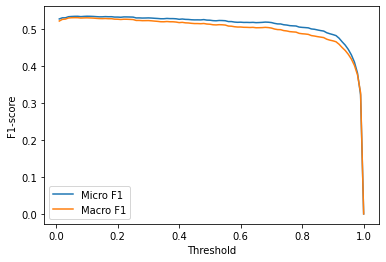

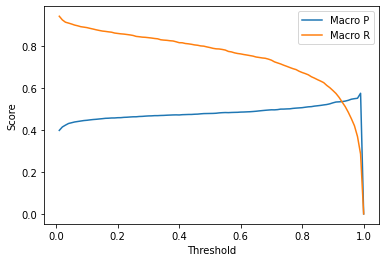

Best threshold (micro): 0.09999999999999999 with F1-score 0.53.
Best threshold (macro): 0.060000000000000005 with F1-score 0.53.
Best threshold (macro-Precision): 0.99 with macroP-score 0.57.
Best threshold (macro-Recall): 0.01 with macroR-score 0.94.
This person conveys {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 5668.57ex/s]


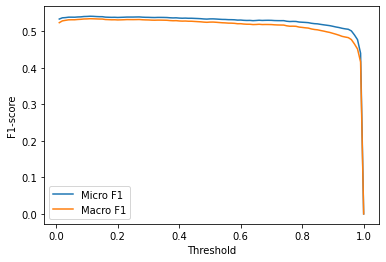

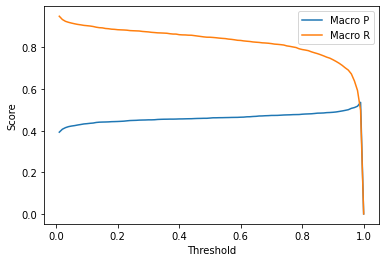

Best threshold (micro): 0.11 with F1-score 0.54.
Best threshold (macro): 0.11 with F1-score 0.53.
Best threshold (macro-Precision): 0.99 with macroP-score 0.54.
Best threshold (macro-Recall): 0.01 with macroR-score 0.95.
This person shows {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 5667.27ex/s]


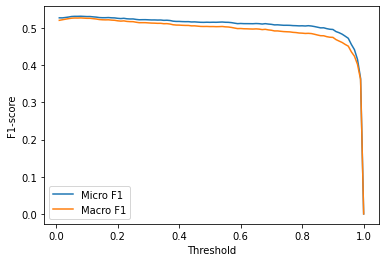

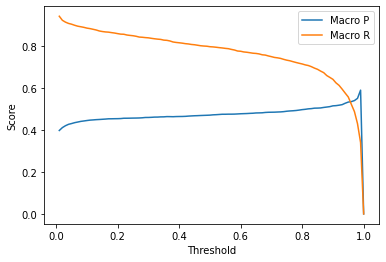

Best threshold (micro): 0.08 with F1-score 0.53.
Best threshold (macro): 0.08 with F1-score 0.53.
Best threshold (macro-Precision): 0.99 with macroP-score 0.59.
Best threshold (macro-Recall): 0.01 with macroR-score 0.94.
This person expresses {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 5478.05ex/s]


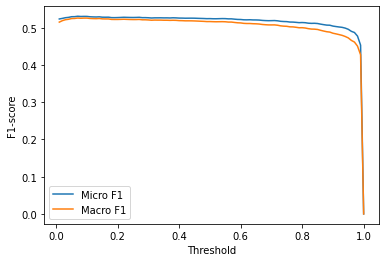

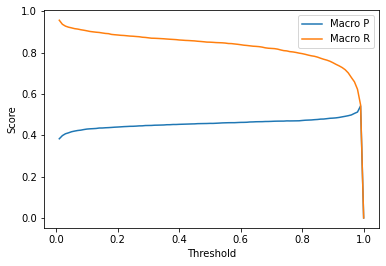

Best threshold (micro): 0.06999999999999999 with F1-score 0.53.
Best threshold (macro): 0.06999999999999999 with F1-score 0.53.
Best threshold (macro-Precision): 0.99 with macroP-score 0.54.
Best threshold (macro-Recall): 0.01 with macroR-score 0.96.
This text is {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 4661.75ex/s]


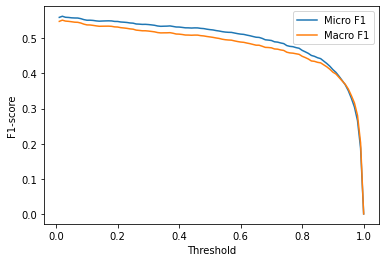

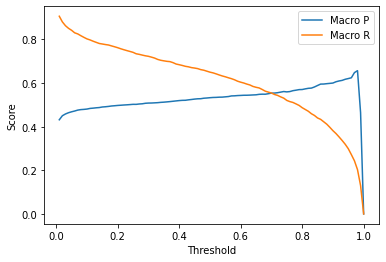

Best threshold (micro): 0.02 with F1-score 0.56.
Best threshold (macro): 0.02 with F1-score 0.55.
Best threshold (macro-Precision): 0.98 with macroP-score 0.66.
Best threshold (macro-Recall): 0.01 with macroR-score 0.91.
This text is about {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 5724.91ex/s]


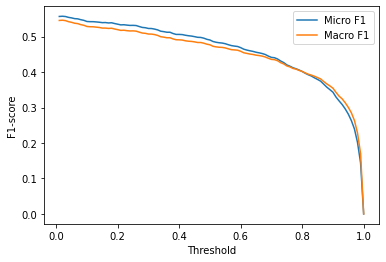

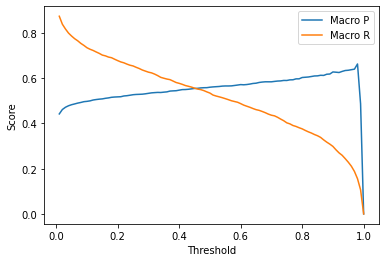

Best threshold (micro): 0.02 with F1-score 0.56.
Best threshold (macro): 0.02 with F1-score 0.55.
Best threshold (macro-Precision): 0.98 with macroP-score 0.66.
Best threshold (macro-Recall): 0.01 with macroR-score 0.87.
This text shows {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2150/2150 [00:00<00:00, 5670.07ex/s]


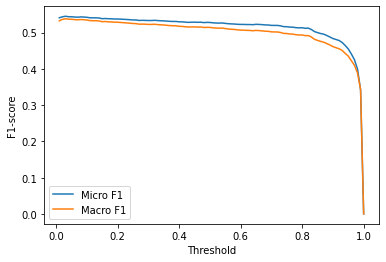

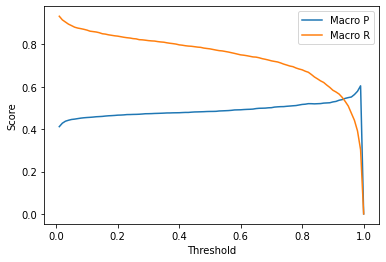

Best threshold (micro): 0.03 with F1-score 0.55.
Best threshold (macro): 0.03 with F1-score 0.54.
Best threshold (macro-Precision): 0.99 with macroP-score 0.60.
Best threshold (macro-Recall): 0.01 with macroR-score 0.93.
This text expresses {}.


  0%|          | 0/2150 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 72%|███████▏  | 1538/2150 [01:32<00:36, 16.56ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
# Use GPU if available
classifier = pipeline('zero-shot-classification', model=zero_shot_model, device=0, fp16=True, batch_size=64)

for ht in h_ts:
    print(ht)
    ait_dataset['valid'] = ait_dataset['valid'].map(zero_shot_pipeline)
    macros, micros, macroprecision, macrorecall = [], [], [], []
    thresholds = np.linspace(0.01, 1, 100)
    for threshold in thresholds:
        ds_zero_shot = ait_dataset['valid'].map(get_preds,
                                        fn_kwargs={"threshold": threshold})
        clf_report = get_clf_report(ds_zero_shot)
        micros.append(clf_report["micro avg"]["f1-score"])
        macros.append(clf_report["macro avg"]["f1-score"])
        macroprecision.append(clf_report['macro avg']['precision'])
        macrorecall.append(clf_report['macro avg']['recall'])
    plt.plot(thresholds, micros, label="Micro F1")
    plt.plot(thresholds, macros, label="Macro F1")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.legend(loc="best")
    plt.show()
    plt.plot(thresholds, macroprecision, label="Macro P")
    plt.plot(thresholds, macrorecall, label="Macro R")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()
    best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
    print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
    best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
    print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
    best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
    print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
    best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
    print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

In [11]:
for ht in h_ts:
    thr = 0.5
    print(ht)
    ait_dataset['test'] = ait_dataset['test'].map(zero_shot_pipeline)    
    thresholds = np.linspace(0.01, 1, 100)
    ds_zero_shot = ait_dataset['test'].map(get_preds, fn_kwargs={'threshold': thr})
    clf_report = get_clf_report(ds_zero_shot)
    print(clf_report)
    df = pd.DataFrame(clf_report).transpose()
    with open(f"classification_report_functions_ait_zero_shot_threshold={thr}_ht={ht}.csv", 'w') as csv_file:
        df.to_csv(path_or_buf=csv_file)        
    ds_zero_shot = ds_zero_shot.map(get_predicted_labels, batched=True)
    ds_zero_shot.set_format("pandas")
    cols = ["text", "functions", "predicted_labels"]
    df_test = ds_zero_shot[:][cols]
    df_test.to_csv(f"preds_functions_ait_zero_shot_threshold={thr}_ht={ht}.tsv",header =True, sep = '\t',index=False)

This person feels {}.


  0%|          | 0/7631 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 7631/7631 [00:01<00:00, 4724.43ex/s]


{'ANGRY': {'precision': 0.4392755681818182, 'recall': 0.9410422213769494, 'f1-score': 0.5989589638058347, 'support': 2629}, 'DISLIKE': {'precision': 0.3379712746858169, 'recall': 0.8193688792165397, 'f1-score': 0.4785510009532888, 'support': 1838}, 'OTHER': {'precision': 0.922077922077922, 'recall': 0.34273373983739835, 'f1-score': 0.4997221707723652, 'support': 3936}, 'PESSIMISTIC': {'precision': 0.48010610079575594, 'recall': 0.8743961352657005, 'f1-score': 0.6198630136986302, 'support': 2691}, 'WORRIED': {'precision': 0.2051026509866454, 'recall': 0.9545454545454546, 'f1-score': 0.33765381460213295, 'support': 1078}, 'micro avg': {'precision': 0.4057478224416601, 'recall': 0.7156588892540257, 'f1-score': 0.517879967896317, 'support': 12172}, 'macro avg': {'precision': 0.47690670334559176, 'recall': 0.7864172860484084, 'f1-score': 0.5069497927664504, 'support': 12172}, 'weighted avg': {'precision': 0.5683874094582826, 'recall': 0.7156588892540257, 'f1-score': 0.530166653118783, 'supp

100%|██████████| 8/8 [00:00<00:00, 149.41ba/s]


This person conveys {}.


  0%|          | 0/7631 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 57%|█████▋    | 4318/7631 [04:26<03:21, 16.41ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 6316/7631 [06:27<01:19, 16.47ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limi

{'ANGRY': {'precision': 0.45585096060547253, 'recall': 0.893495625713199, 'f1-score': 0.6037008481110254, 'support': 2629}, 'DISLIKE': {'precision': 0.34602244997559783, 'recall': 0.7714907508161044, 'f1-score': 0.4777628032345014, 'support': 1838}, 'OTHER': {'precision': 0.9245152354570637, 'recall': 0.3391768292682927, 'f1-score': 0.4962825278810409, 'support': 3936}, 'PESSIMISTIC': {'precision': 0.47766749379652607, 'recall': 0.8584169453734671, 'f1-score': 0.6137903547229971, 'support': 2691}, 'WORRIED': {'precision': 0.22119815668202766, 'recall': 0.8905380333951762, 'f1-score': 0.35437430786268, 'support': 1078}, 'micro avg': {'precision': 0.42131749786120476, 'recall': 0.6878080841275057, 'f1-score': 0.522547826358331, 'support': 12172}, 'macro avg': {'precision': 0.4850508593033376, 'recall': 0.7506236369132478, 'f1-score': 0.509182168362449, 'support': 12172}, 'weighted avg': {'precision': 0.5748577262533369, 'recall': 0.6878080841275057, 'f1-score': 0.5300978426063285, 'suppo

100%|██████████| 8/8 [00:00<00:00, 134.49ba/s]


The communicative intention of this text is {}.


  0%|          | 0/7631 [00:00<?, ?ex/s]/home/njfernandez/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  6%|▋         | 490/7631 [00:32<08:20, 14.27ex/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

